# Tensorflow training  
Es ist zu vermuten, dass ein Neuronales Netz, das auf das Erkennen von Plakaten trainiert worden ist zu sinnigeren Clustern kommt. Von daher soll mittels dieses Notebooks ein Neuronales Netz auf einen Trainingsdatensatz trainiert werden.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
path = "/home/julius/PowerFolders/Masterarbeit/1_Datensaetze/tensorflow"

Nach den Imports und dem Verweis auf den Speicherort des Datensatzes wird dieser mittels der _image_dataset_from_directory_ Funktion importiert. Da der Datensatz in keine Untergliederung in Training und Testing hat, wird der Funktion die entsprechenden Parameter mitgegeben. Gleichzeitig wird die Größe der Bilder und die Größer ihrer Batches, also die Größe der Bündel, in die sie eingeteilt werden, definiert.

In [3]:
train_dataset = image_dataset_from_directory(path, validation_split=0.25, subset="training", seed=123, image_size=(160, 160), batch_size=32)
validation_dataset = image_dataset_from_directory(path, validation_split=0.25, subset="validation", seed=123, image_size=(160, 160), batch_size=32)

Found 800 files belonging to 8 classes.
Using 600 files for training.
Found 800 files belonging to 8 classes.
Using 200 files for validation.


In [4]:
class_names = train_dataset.class_names

Wie eine Stichprobe eines Batches zeigt, scheinen sowohl die Bilder als auch die Kategorien korrekt eingelesen zu sein.

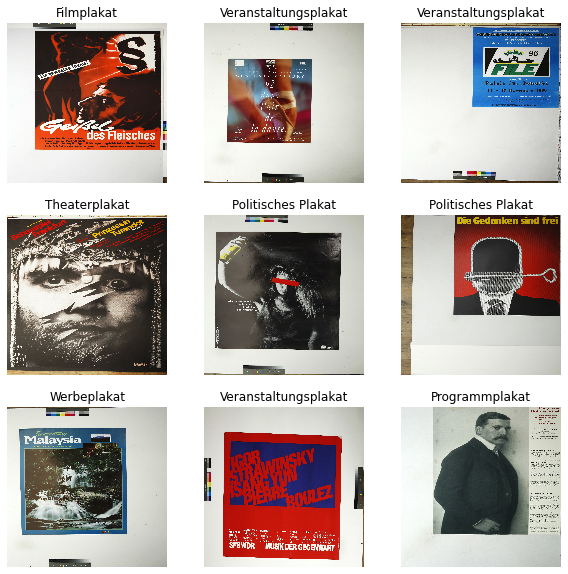

In [5]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Neben der Gliederung in Training und Test Daten soll auch eine Unterteilung in Validierungsdaten geschehen. Hierzu werden die Batches des Testdatensatzes in zwei Hälften geteilt und dem Datensatz zur Validierung zugesprochen

In [6]:
validation_batchs = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_batchs//2)
validation_dataset = validation_dataset.skip(validation_batchs//2)

In [7]:
print("Number of validation batches: {}".format(tf.data.experimental.cardinality(validation_dataset)))
print("Number of test batches: {}".format(tf.data.experimental.cardinality(test_dataset)))

Number of validation batches: 4
Number of test batches: 3


Für eine 

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

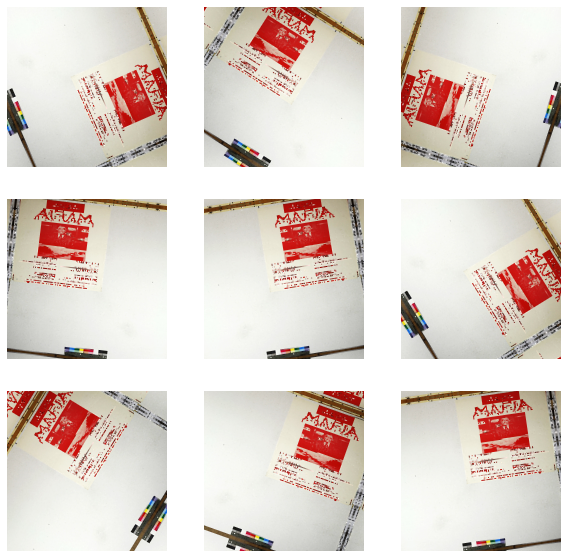

In [10]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0]/255)
        plt.axis("off")

In [11]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [24]:
IMG_SHAPE = (160, 160) + (3,)

base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")

In [25]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [26]:
base_model.trainable=False

In [27]:
base_model.summary()

4_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 20, 20, 512)  0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 10, 10, 256)  131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 10, 10, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 10, 10, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 10, 10, 256)  590080      conv4_block1_1_relu[0

In [28]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [43]:
prediction_layer = tf.keras.layers.Dense(8)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 8)


In [44]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [45]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [46]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_3 ( (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add_3 (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0   

In [47]:
len(model.trainable_variables)

2

In [48]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(test_dataset)

4/4 [==============================] - 5s 564ms/step - loss: 2.5015 - accuracy: 0.1901


In [49]:
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10
19/19 [==============================] - 24s 1s/step - loss: 2.7207 - accuracy: 0.1267 - val_loss: 2.6503 - val_accuracy: 0.1635
Epoch 2/10
19/19 [==============================] - 22s 1s/step - loss: 2.4701 - accuracy: 0.1683 - val_loss: 2.4403 - val_accuracy: 0.2500
Epoch 3/10
19/19 [==============================] - 22s 1s/step - loss: 2.4334 - accuracy: 0.1933 - val_loss: 2.4587 - val_accuracy: 0.1731
Epoch 4/10
19/19 [==============================] - 22s 1s/step - loss: 2.3050 - accuracy: 0.1867 - val_loss: 2.3134 - val_accuracy: 0.1827
Epoch 5/10
19/19 [==============================] - 22s 1s/step - loss: 2.3007 - accuracy: 0.2133 - val_loss: 2.3865 - val_accuracy: 0.1538
Epoch 6/10
19/19 [==============================] - 22s 1s/step - loss: 2.1984 - accuracy: 0.2150 - val_loss: 2.3640 - val_accuracy: 0.2019
Epoch 7/10
19/19 [==============================] - 22s 1s/step - loss: 2.1671 - accuracy: 0.2400 - val_loss: 2.2702 - val_accuracy: 0.2019
Epoch 8/10
19/19 [==

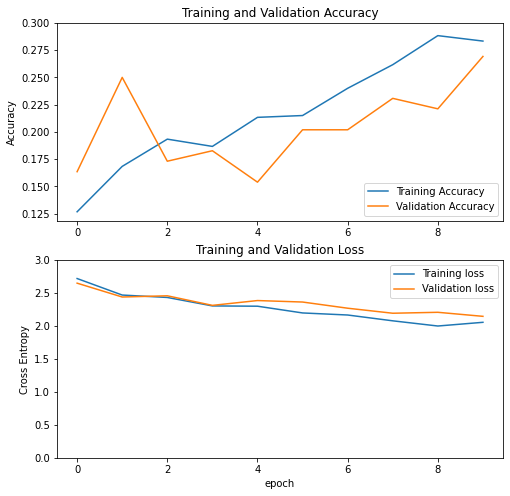

In [51]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 0.3])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 3.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

In [52]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [53]:
fine_tune_at = 125
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [54]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10), metrics=["accuracy"])

In [55]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_3 ( (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add_3 (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0   

In [56]:
len(model.trainable_variables)

62

In [57]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=validation_dataset)

Epoch 10/20
19/19 [==============================] - 42s 2s/step - loss: 1.9206 - accuracy: 0.3349 - val_loss: 2.0544 - val_accuracy: 0.2692
Epoch 11/20
19/19 [==============================] - 38s 2s/step - loss: 1.7056 - accuracy: 0.3716 - val_loss: 1.9994 - val_accuracy: 0.2500
Epoch 12/20
19/19 [==============================] - 38s 2s/step - loss: 1.6752 - accuracy: 0.4058 - val_loss: 2.0156 - val_accuracy: 0.3077
Epoch 13/20
19/19 [==============================] - 38s 2s/step - loss: 1.4506 - accuracy: 0.4444 - val_loss: 2.0489 - val_accuracy: 0.2596
Epoch 14/20
19/19 [==============================] - 38s 2s/step - loss: 1.4637 - accuracy: 0.4880 - val_loss: 2.1550 - val_accuracy: 0.2404
Epoch 15/20
19/19 [==============================] - 38s 2s/step - loss: 1.3497 - accuracy: 0.5058 - val_loss: 2.1761 - val_accuracy: 0.2404
Epoch 16/20
19/19 [==============================] - 38s 2s/step - loss: 1.2730 - accuracy: 0.5441 - val_loss: 1.9978 - val_accuracy: 0.3269
Epoch 17/20
1

In [58]:
acc += history_fine.history["accuracy"]
val_acc += history_fine.history["val_accuracy"]

loss += history_fine.history["loss"]
val_loss += history_fine.history["val_loss"]

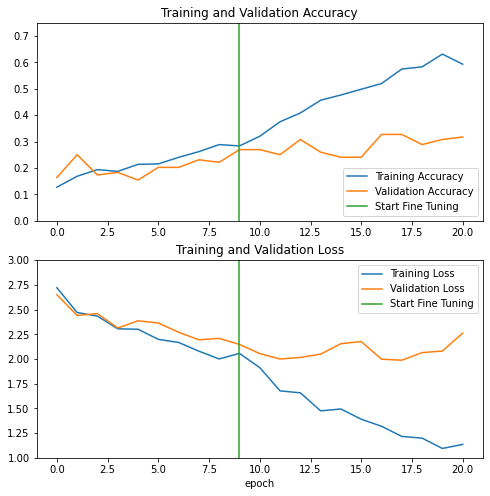

In [60]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.ylim([0, 0.75])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([1.0, 3.0])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

In [61]:
model.evaluate(test_dataset)

3/3 [==============================] - 4s 749ms/step - loss: 1.9362 - accuracy: 0.3542


[1.9362236261367798, 0.3541666567325592]